# **LDA with priors pipeline**

# 0. Packages

In [1]:
# Core libraries
import os
import re
import sys
import ast
import csv
import math
import pickle
import subprocess
from collections import Counter
from itertools import chain
from typing import Union

# Data handling and computation
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm
tqdm.pandas()  # Initialize progress bars for pandas


# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.ticker as mticker


# NLP - NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords

# NLP - spaCy
import spacy

# NLP - Language detection
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# NLP - Vectorization & Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus

# LDA
from gensim import corpora, models
from gensim.models import LdaModel

# Statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix


c:\Users\aleja\anaconda3\envs\myenv\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


# 1. Importing the data

## Importing Song lyrics

In [2]:

import os

os.chdir(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\Text_mining_final_project")
print("Current working directory:", os.getcwd())

# Songs dataset with lyrics
df = pd.read_csv(os.path.join('Spotify-Genius', 'billboard_hot_100_2004_2024_total.csv'))

df.head()

Current working directory: C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\Text_mining_final_project


,year,ranking,title,artist,lyrics,song_url,producers,writers,label,released_on,tags,month,In English,Pop,Rap,R&B,Electro-Pop,Rock,usa,year_month
0,2004,1,Yeah!,Usher featuring Lil Jon and Ludacris,"[Intro: USHER & Lil Jon]\r\nPeace up, A-Town d...",https://genius.com/usher-yeah-lyrics,['Lil Jon'],"['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...","['Arista Records', 'LaFace Records']","January 27, 2004","['Crunk', 'Pop Rap', 'Contemporary R&B', 'Dirt...",1,1,1,1,1,0,0,1,2004-01
1,2004,2,Burn,Usher,"[Intro]\r\nGirl, I understand why\r\nSee, it's...",https://genius.com/usher-burn-lyrics,"['Jermaine Dupri', 'Bryan-Michael Cox']","['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']","['LaFace Records', 'Arista Records']","March 21, 2004","['Soul Pop', 'USA', 'Soul', 'Pop', 'R&B', 'In ...",3,1,1,0,1,0,0,1,2004-03
2,2004,3,If I Ain't Got You,Alicia Keys,"[Intro]\r\nMm-mm\r\nMm-mm, oh\r\nMm-mm\r\n[Ver...",https://genius.com/alicia-keys-if-i-aint-got-y...,['Alicia Keys'],['Alicia Keys'],['J Records'],"February 17, 2004","['Ballad', 'R&B', 'In English', 'Soul Pop', 'U...",2,1,1,0,1,0,0,1,2004-02
3,2004,4,This Love,Maroon 5,[Verse 1]\r\nI was so high I did not recognize...,https://genius.com/maroon-5-this-love-lyrics,"['Mark Endert', 'Matt Wallace']","['Jesse Carmichael', 'Adam Levine']","['J Records', 'Octone Records']","June 25, 2002","['Alternative R&B', 'Bubblegum Pop', 'Pop-Rock...",6,1,1,0,1,0,1,1,2004-06
4,2004,5,The Way You Move,OutKast featuring Sleepy Brown,"[Intro: Big Boi]\r\nBoom, boom, boom\r\nHa-ha!...",https://genius.com/outkast-the-way-you-move-ly...,"['Big Boi', 'Carl Mo']","['Sleepy Brown', 'Big Boi', 'Carl Mo']","['Arista Records', 'LaFace Records']","September 23, 2003","['Atlanta Rap', 'In English', 'Soul Pop', 'Sou...",9,1,0,1,1,0,0,1,2004-09


## Importing Concepnet already preprocessed data

In [3]:
# Load the CSV file into a DataFrame
df_cnet = pd.read_csv(os.path.join('ConceptNet', 'concept_net_terms_preprocessed.csv'))

# 2. Cleaning the data

## Creating true release date column

In [4]:
# Convert the column to datetime
df['released_on'] = pd.to_datetime(df['released_on'], format = 'mixed')

# Extract the year
df['release_year'] = df['released_on'].dt.year

# Extract the month
df['release_month'] = df['released_on'].dt.month

# Change the values in "year_month" to the release year and month (instead of
# Billboard year and month of release)
df['release_year_month'] = df['release_year'].astype(str) + '-' + df['release_month'].astype(str).str.zfill(2)

In [5]:
# Dropping all observations prior to 2004
df = df[df['release_year'] >= 2004]

## Importing functions

In [6]:
# Define preprocessing function
def preprocess_lower(text, rm_stopwords = False, stopword_set = None):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation and digits.
       - Tokenizing.
       - Removing stopwords (optional).
    
    Returns:
        list: A list of tokens lowercased and without punctuation.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)  # Remove digits and punctuation, replace by whitespace
    tokens = word_tokenize(text_no_punct)
    tokens = word_tokenize(text_no_punct)
    # Remove stopwords if desired
    if rm_stopwords == True:
        tokens = [token for token in tokens if token not in stopword_set]
    # We return the whole string of tokens so that we can find n-grams later
    return " ".join(tokens)

# Define stopwords
my_stop_words = set(stopwords.words('english'))

# Create set of custom stopwords (optional)
my_custom_stopwords = {'intro', 'verse', 'chorus', 'bridge'} 

# Update stopwords (optional)
my_stop_words.update(my_custom_stopwords)

my_stop_words = set(stopwords.words('english'))

In [7]:
def preprocess_lemmatize(text):
    """
    Preprocess text by applying lemmatized.
    Should just input a string which has been previously pre-processed, which at least removes
    the punctuation.

    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """

    tokens = text.split()  # Split input text based on whitespaces
    lemmatizer = WordNetLemmatizer()  # Initiallize lemmatizer
    lemmatized_text = []  # Initialize empty list to store lemmatized text
    for word in tokens:
        lemmatized_text.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_text)

## Tokenizing and stopword removal

In [8]:
# Apply the preprocessing function to the 'lyrics' column
df['lyrics_lower'] = df['lyrics'].apply(
    lambda row: preprocess_lower(text=row, rm_stopwords=True, stopword_set=my_stop_words)
)

## Lemmatizing

In [9]:
df['lyrics_lemmatized'] = df['lyrics_lower'].progress_apply(
    lambda row: preprocess_lemmatize(text = row)
    )

100%|██████████| 2022/2022 [00:02<00:00, 851.63it/s] 


# LDA with priors

## Input term with custom dictionary

In [10]:
# Create a dictionary where keys are input_term values
# and values are lists of (label_lower, weight_normalized) tuples
input_term_dict = {
    term: list(df_cnet[df_cnet['input_term'] == term][['label_lower', 'weight_normalized']].itertuples(index=False, name=None))
    for term in df_cnet['input_term'].unique()
}

In [11]:
# Input term dictionary
for k, v in input_term_dict.items():
    print(f"{k}: {v}")


health: [('well', 8.892176439312824), ('wellbeing', 7.38661714350238), ('condition', 7.38661714350238), ('good', 7.328835083130087), ('well', 6.805397595051658), ('body', 6.11201287058413), ('healthiness', 3.9876724157203793), ('sanidad', 3.9876724157203793), ('heartiness', 3.9876724157203793), ('malfunction', 3.9876724157203793), ('toast', 3.9876724157203793), ('everyone', 3.9876724157203793), ('function', 3.9876724157203793), ('mental', 3.9876724157203793), ('video games', 3.9876724157203793), ('prosperity', 3.9876724157203793), ('organism', 3.9876724157203793), ('physical', 3.9876724157203793), ('whole', 3.9876724157203793), ('heal', 3.9876724157203793), ('salud', 3.9876724157203793), ('social', 3.9876724157203793), ('illness', 3.9876724157203793), ('state', 3.9876724157203793), ('disease', 3.9876724157203793), ('sickness', 3.9876724157203793), ('robustness', 3.9876724157203793), ('important', 3.9876724157203793), ('psychological', 3.9876724157203793), ('wellness', 3.987672415720379

## Training the LDA model

In [12]:
# Create a new column 'word_count' by counting the number of words in each preprocessed text
df = df.dropna(subset=["lyrics_lemmatized"])
df["word_count"] = df["lyrics_lemmatized"].apply(lambda x: len(x.split()))

# Drop rows where the word count is less than 10
df = df[df["word_count"] >= 10]

In [13]:
# Define custom stopwords (case-sensitive)
custom_stopwords_list = [
    "verse", "chorus", "la", "oh", "da", "ta", "ody", "ayy", "ah", "ohoh", "yeah",
    "m", "s", "1", "2", "ooh", "doo", "woah", "ha", "wop", "duh", "ooo", "dey", "sa",
    "woo", "huh", "huh huh", "huh huh huh", "ugh", "ho", "ou", "ud", "de", "eh",
    "mmm", "ba", "yo", "hey", "ay", "ya", "te", "ding", "dong", "hmm", "mmmm"
]

custom_stopwords = set(STOPWORDS).union(set(word.lower() for word in custom_stopwords_list))

# Convert lyrics_lemmatized column to lowercase
df['lyrics_lemmatized'] = df['lyrics_lemmatized'].apply(lambda x: str(x).lower())

# **Step 1: Remove stopwords from the entire corpus before generating word clouds**
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in custom_stopwords]
    return " ".join(filtered_words)

# Apply stopword removal to the entire column
df['lyrics_lemmatized'] = df['lyrics_lemmatized'].apply(remove_stopwords)

In [14]:
# Creating DTM
cv = CountVectorizer(ngram_range = (1,3), lowercase=False, max_df=0.6)
cv.fit(df.lyrics_lemmatized)
vectorized_text=cv.transform(df.lyrics_lemmatized)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (2019, 247474)


In [15]:
# Convert the document-term matrix to sparse format
dtm_sparse = csr_matrix(vectorized_text)

# Convert sparse matrix to Gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create Gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {val: key for key, val in cv.vocabulary_.items()}  # inverse mapping
dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

# Build full eta matrix including extra unsupervised topics
def build_eta_matrix_with_extra_topics(input_term_dict, dictionary, extra_topics,
                                       base_eta, min_boost_eta, max_boost_eta):
    """
    Builds a custom eta matrix with priors from input_term_dict and adds extra unsupervised topics.
    
    Parameters:
    - input_term_dict: dict {topic_name (str): list of (word, weight)}
    - dictionary: Gensim Dictionary
    - extra_topics: how many unsupervised topics to add
    - base_eta: default prior for all words
    - min_boost_eta, max_boost_eta: range of eta values for seed words
    
    Returns:
    - eta matrix (num_topics x vocab_size)
    - topic_name_to_id mapping
    - total number of topics
    """
    topic_names = list(input_term_dict.keys())
    topic_to_id = {topic_name: i for i, topic_name in enumerate(topic_names)}
    seeded_topics = len(topic_names)
    num_topics = seeded_topics + extra_topics
    vocab_size = len(dictionary)
    
    eta = np.full((num_topics, vocab_size), base_eta)

    for topic_name, word_weights in input_term_dict.items():
        topic_id = topic_to_id[topic_name]
        weights = np.array([w for _, w in word_weights])
        if len(weights) > 0:
            w_min, w_max = weights.min(), weights.max()
            if w_max > w_min:
                scaled_weights = min_boost_eta + (weights - w_min) / (w_max - w_min) * (max_boost_eta - min_boost_eta)
            else:
                scaled_weights = np.full_like(weights, max_boost_eta)

            for (word, _), eta_value in zip(word_weights, scaled_weights):
                if word in dictionary.token2id:
                    word_id = dictionary.token2id[word]
                    eta[topic_id, word_id] = eta_value

    return eta, topic_to_id, num_topics

# Build eta matrix from weighted priors with extra unsupervised topics
eta, topic_to_id, num_topics = build_eta_matrix_with_extra_topics(
    input_term_dict=input_term_dict,
    dictionary=dictionary,
    extra_topics=5,        # Number of EXTRA topics, we can modify this.
    base_eta=0.01,
    min_boost_eta=0.8,
    max_boost_eta=1000.0
)

# Train the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    alpha='auto',
    eta=eta,
    passes=10,
    random_state=42
)

# Display topics
topics = lda_model.print_topics(num_words=50)
for topic in topics:
    print(topic)
    print("")

# Get document-topic distributions
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

# Optional: structured topic-word tuples
topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)

(0, '0.030*"good" + 0.028*"health" + 0.020*"condition" + 0.019*"body" + 0.015*"look" + 0.012*"dance" + 0.010*"everyone" + 0.010*"whole" + 0.010*"state" + 0.010*"sick" + 0.010*"toast" + 0.010*"mental" + 0.010*"heal" + 0.010*"important" + 0.010*"disease" + 0.009*"balance" + 0.009*"function" + 0.009*"physical" + 0.009*"salud" + 0.009*"social" + 0.008*"fly" + 0.008*"look good" + 0.007*"look fly" + 0.006*"medical" + 0.006*"night" + 0.006*"feeling" + 0.006*"tonight" + 0.006*"baby" + 0.006*"dance dance" + 0.006*"feeling good" + 0.006*"right" + 0.006*"mon" + 0.006*"mama" + 0.005*"victoria" + 0.005*"well" + 0.004*"status" + 0.004*"wan na" + 0.004*"wan" + 0.004*"na" + 0.004*"cause" + 0.004*"see" + 0.004*"say" + 0.004*"pre" + 0.004*"away" + 0.004*"put" + 0.004*"bag" + 0.004*"hood" + 0.004*"wish" + 0.004*"watch" + 0.004*"touch"')

(1, '0.074*"justice" + 0.066*"judge" + 0.066*"court" + 0.066*"judgment" + 0.033*"people" + 0.033*"wrong" + 0.031*"blind" + 0.031*"fair" + 0.031*"law" + 0.031*"title" + 0

## Time series Plot

In [16]:
# Initialize the columns for each topic with default value 0
for topic_num in range(num_topics):
    df[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        df.at[i, f'topic_{topic_num}'] = prob

# df now contains the topic distributions for each document

In [17]:
# Aggregating topic shares
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.05775247 0.02932714 0.12020026 0.05726752 0.05443239 0.09484369
 0.15080261 0.15375005 0.19464326 0.03153515]
Total alpha prior: 0.9445545487105846


In [18]:
# For each topic column, calculate the words attributed to that topic
for i in range(num_topics):
    df[f'words_topic_{i}'] = df[f'topic_{i}'] * df['word_count']

In [19]:
# Prepare the data for aggregation
aggregation_data = df[['release_year_month'] + [f'words_topic_{i}' for i in range(num_topics)]]

# Group by year_month and sum the word counts for topics
grouped_data = aggregation_data.groupby(['release_year_month']).sum().reset_index()

# Adjust weights using the prior
pweight = 1
for i in range(num_topics):
    grouped_data[f'topic_share_{i}'] = (
        grouped_data[f'words_topic_{i}'] + pweight * alpha_prior[i]
    ) / (grouped_data[[f'words_topic_{j}' for j in range(num_topics)]].sum(axis=1) + pweight * total_alpha_prior)

# Select the final output columns
final_columns = ['release_year_month'] + [f'topic_share_{i}' for i in range(num_topics)]
result_df = grouped_data[final_columns]


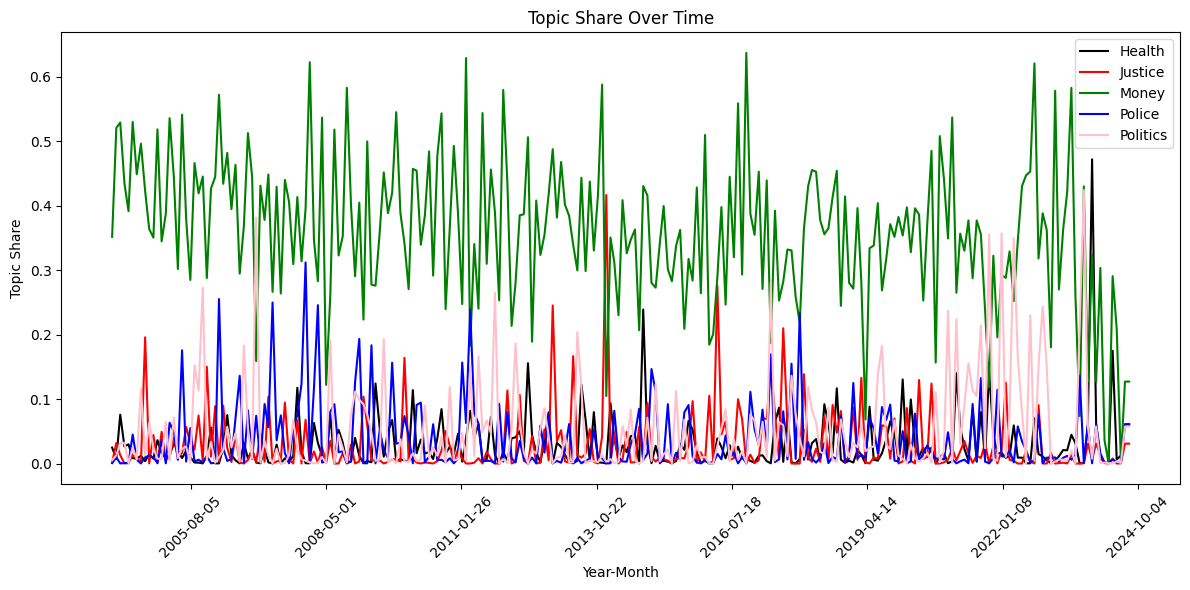

In [20]:
# Ensure release_year_month is datetime (if not already)
result_df.loc[:, 'release_year_month'] = pd.to_datetime(result_df['release_year_month'], format='%Y-%m')

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time
plt.plot(result_df['release_year_month'], result_df['topic_share_0'], label='Health', color='black')
plt.plot(result_df['release_year_month'], result_df['topic_share_1'], label='Justice', color='red')
plt.plot(result_df['release_year_month'], result_df['topic_share_2'], label='Money', color='green')
plt.plot(result_df['release_year_month'], result_df['topic_share_3'], label='Police', color='blue')
plt.plot(result_df['release_year_month'], result_df['topic_share_4'], label='Politics', color='pink')

# Formatting X-axis
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Optional: remove if messy with datetimes

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Topic Share Over Time')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# Comparison with Google Trends Data

## Importing clean Google Trends Data

In [21]:
df_gt = pd.read_csv(os.path.join('google_trends', 'multiTimeline.csv'), skiprows = 2)

df_gt = df_gt.rename(columns = {'health: (United States)': 'Health',
                                'money: (United States)': 'Money',
                                'justice: (United States)': 'Justice',
                                'police: (United States)': 'Police',
                                'politics: (United States)': 'Politics'})

df_gt.head()

,Month,Health,Money,Justice,Police,Politics
0,2004-01,82,30,10,31,4
1,2004-02,80,29,11,28,5
2,2004-03,79,30,10,30,5
3,2004-04,79,30,11,29,5
4,2004-05,74,28,9,29,4


In [22]:
# Renamming LDA for easy plotting
result_df = result_df.rename(columns={
    'topic_share_0': 'Health',
    'topic_share_1': 'Justice',
    'topic_share_2': 'Money',
    'topic_share_3': 'Police',
    'topic_share_4': 'Politics'
})

In [25]:
def plot_dual_axis(df_primary, df_secondary, topics, secondaries, title_file, x_col='Month'):
    """
    Plots subplots with dual y-axes for each topic and its corresponding secondary data.

    Parameters:
    - df_primary: DataFrame containing the primary data.
    - df_secondary: DataFrame containing the secondary data.
    - topics: List of column names for primary y-axis data.
    - secondaries: List of column names for secondary y-axis data.
    - x_col: Column name for x-axis data (default is 'Month').
    """
    num_plots = len(topics)
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 3 * num_plots), sharex=True)

    if num_plots == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors  # Color palette

    for i, (topic, secondary) in enumerate(zip(topics, secondaries)):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        # Plot primary data
        ax1.plot(df_primary[x_col], df_primary[topic], color=colors[i % len(colors)], label=topic, alpha = 1)
        ax1.set_ylabel('Google Trends Index')
        ax1.tick_params(axis='y')

        # Plot secondary data
        ax2.plot(df_secondary[x_col], df_secondary[secondary], color='grey', linestyle='--', label=secondary, alpha = 0.7)
        ax2.set_ylabel('Relative Relevance Score')
        ax2.tick_params(axis='y')

        # Title and grid
        ax1.set_title(f'{topic}')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Rotate x-axis labels for readability
        ax1.tick_params(axis='x', rotation=45)

        plt.legend(loc = 'upper right')

    plt.xlabel(x_col)
    plt.tight_layout()
    plt.savefig('../Text_mining_final_project/figures/' + title_file + '.png', dpi = 400, bbox_inches = 'tight')
    plt.show()

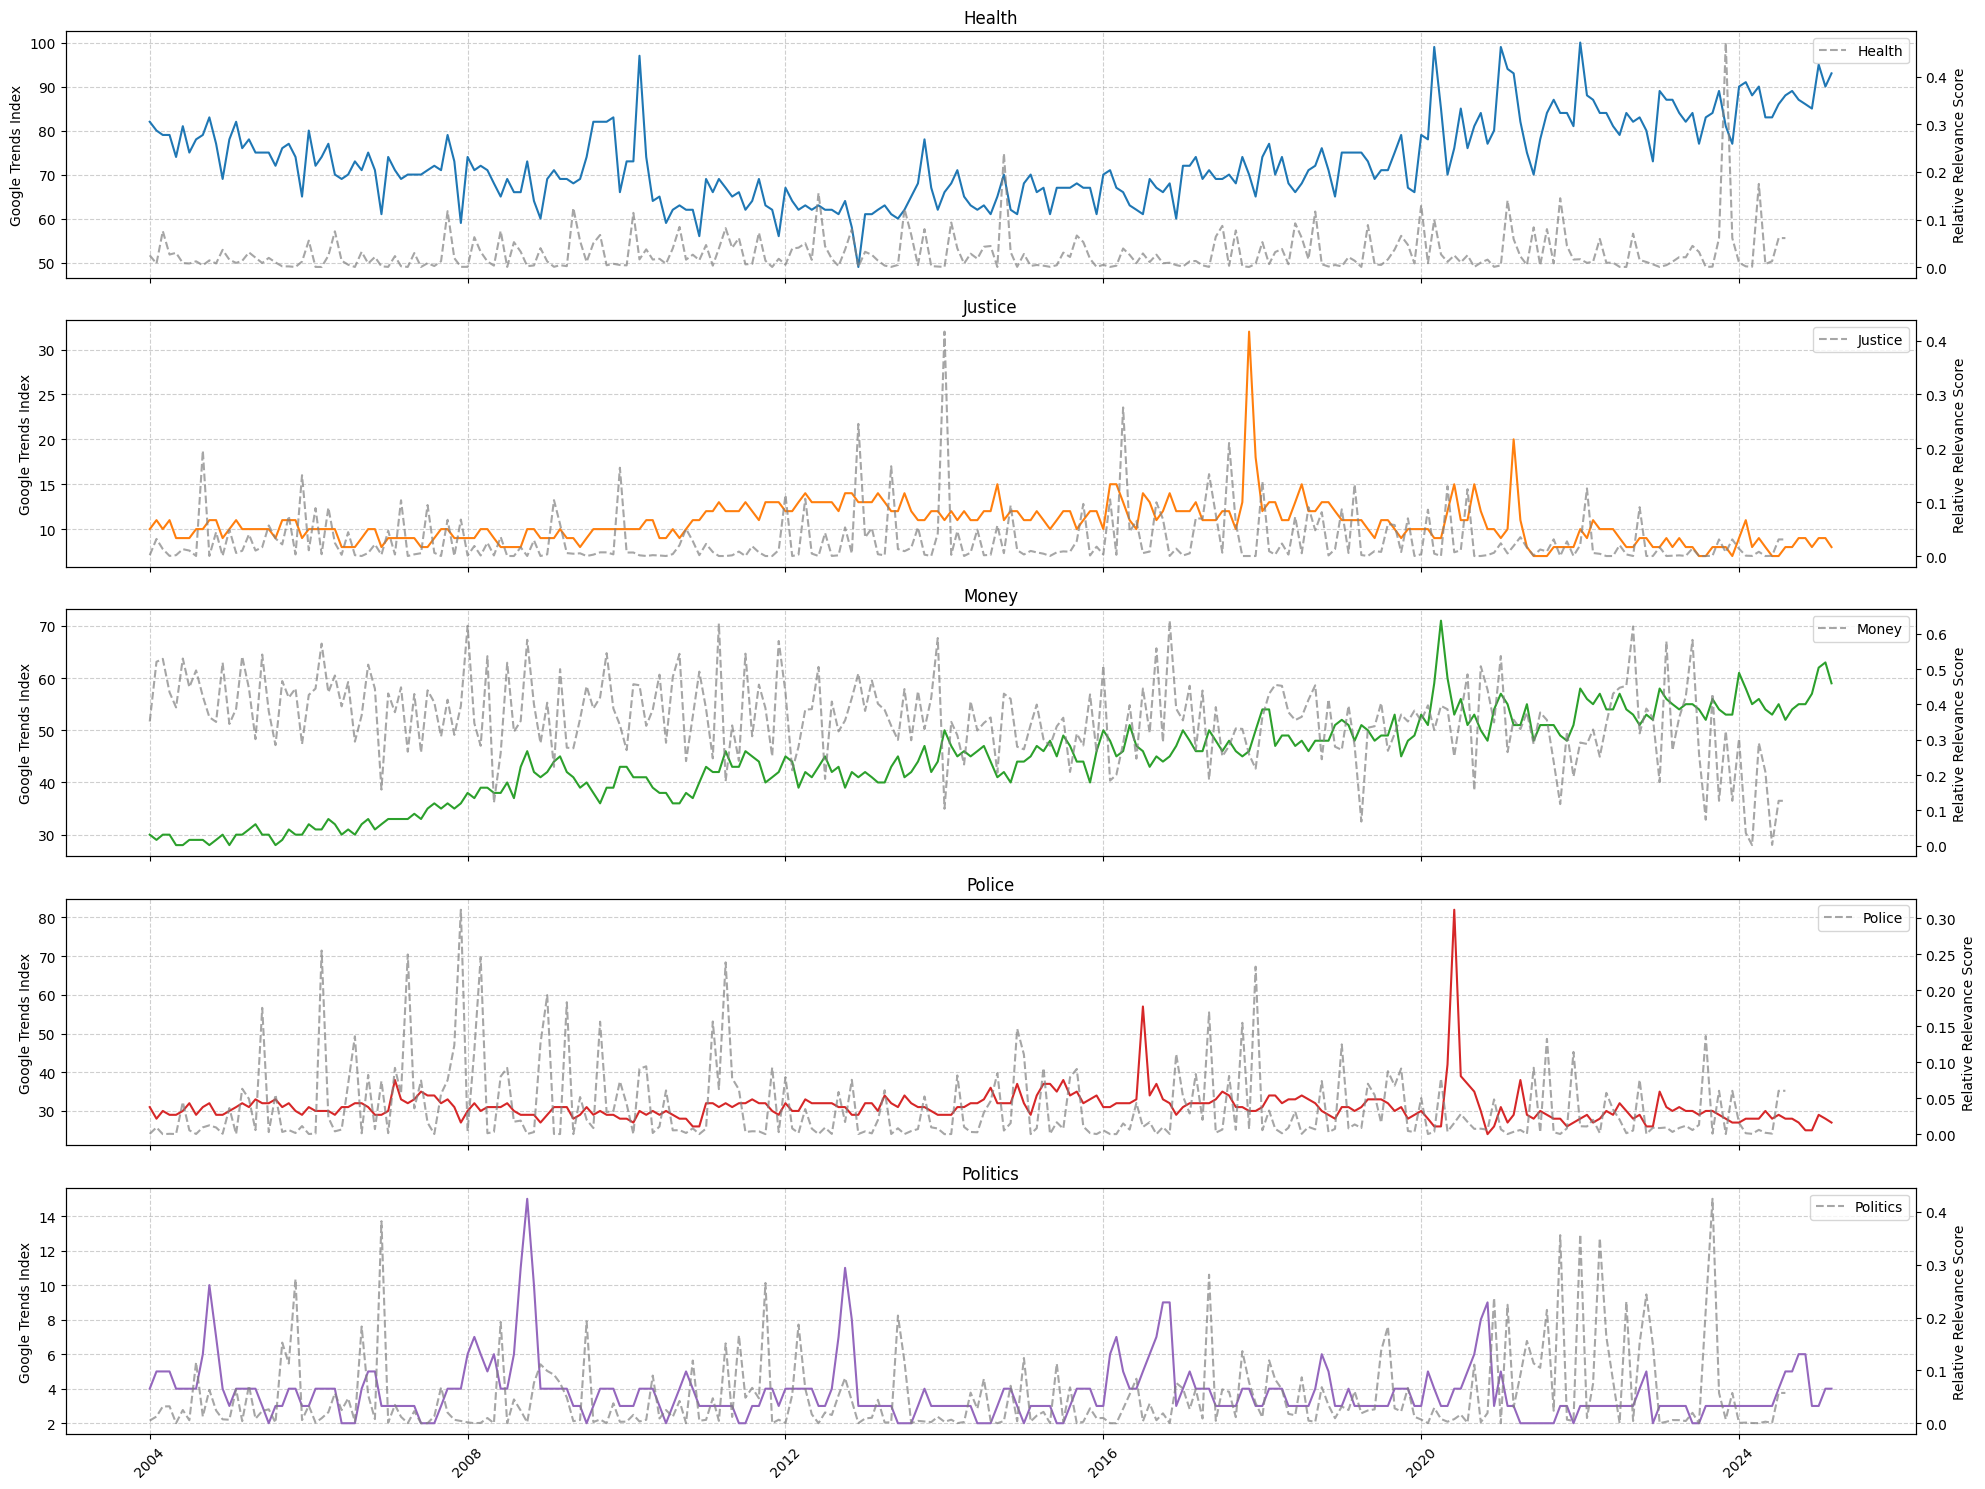

In [26]:
# Ensure datetime format if not already done
result_df['Month'] = pd.to_datetime(result_df['release_year_month'], format='%Y-%m')
df_gt['Month'] = pd.to_datetime(df_gt['Month'], format='%Y-%m')

# Define topics
topics = ['Health', 'Justice', 'Money', 'Police', 'Politics']

# Assuming you're using the same topic names for both dataframes,
# if not, adjust 'secondaries' accordingly (e.g., GT column names)
secondaries = topics

# Call the function
plot_dual_axis(
    df_primary=df_gt,          # Google Trends data
    df_secondary=result_df,    # LDA data
    topics=topics,
    secondaries=secondaries,
    title_file='lda_vs_google_trends_topics',
    x_col='Month'
)

# Exporting data for regressions

In [24]:
# Rename columns
result_df = result_df.rename(columns={
    'topic_share_0': 'relative_relevance_health',
    'topic_share_1': 'relative_relevance_justice',
    'topic_share_2': 'relative_relevance_money',
    'topic_share_3': 'relative_relevance_police',
    'topic_share_4': 'relative_relevance_politics'
})

# Export to CSV
result_df.to_csv('result_relative_relevance_LDA_priors.csv', index=False)
